In [1]:
import importlib

import settings
import VPINN_tri
import mesh_lib

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from GaussJacobiQuadRule_V3 import Jacobi, DJacobi, GaussLobattoJacobiWeights
import os 

importlib.reload(settings)
importlib.reload(mesh_lib)
importlib.reload(VPINN_tri)

from settings import *
from mesh_lib import *
from VPINN_tri import *



os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

settings_lib imported 


2023-11-14 11:24:56.222617: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-14 11:24:56.224124: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-14 11:24:56.257204: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-14 11:24:56.258235: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 11:24:56.843101: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

interpolator_lib imported
VPINN_tri_lib  imported
mesh_lib imported
settings_lib imported 
mesh_lib imported
VPINN_tri_lib  imported


basis:
basis function number :  1

1 x^0 y^0 -3 x^1 y^0 2 x^2 y^0 -3 x^0 y^1 4 x^1 y^1 2 x^0 y^2 

basis function number :  2

0 x^0 y^0 4 x^1 y^0 -4 x^2 y^0 0 x^0 y^1 -4 x^1 y^1 0 x^0 y^2 

basis function number :  3

0 x^0 y^0 -1 x^1 y^0 2 x^2 y^0 0 x^0 y^1 0 x^1 y^1 0 x^0 y^2 

basis function number :  4

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 4 x^0 y^1 -4 x^1 y^1 -4 x^0 y^2 

basis function number :  5

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 0 x^0 y^1 4 x^1 y^1 0 x^0 y^2 

basis function number :  6

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 -1 x^0 y^1 0 x^1 y^1 2 x^0 y^2 

basis :
d1x
basis function number :  1

-3 x^0 y^0 4 x^1 y^0 4 x^0 y^1 

d1y
basis function number :  1

-3 x^0 y^0 4 x^1 y^0 4 x^0 y^1 


d1x
basis function number :  2

4 x^0 y^0 -8 x^1 y^0 -4 x^0 y^1 

d1y
basis function number :  2

0 x^0 y^0 -4 x^1 y^0 0 x^0 y^1 


d1x
basis function number :  3

-1 x^0 y^0 4 x^1 y^0 0 x^0 y^1 

d1y
basis function number :  3

0 x^0 y^0 0 x^1 y^0 0 x^0 y^1 


d1x
basis function number :  4

0 x^0 y^0 0 

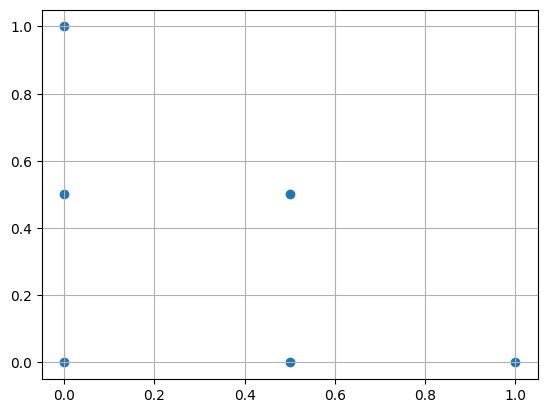

In [2]:
basis=interpolator(2,True,False,points=None)

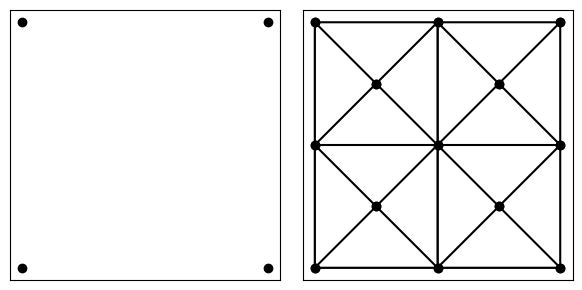

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import triangle as tr



# Step 1: Generate a fine mesh
A = dict(vertices=np.array(((0, 0), (1, 0), (1, 1), (0, 1))))
B = tr.triangulate(A,'qnea0.1')

tr.compare(plt, A, B)

[[ 4 12]
 [ 9 12]
 [ 4  9]
 [ 4  8]
 [ 4  5]
 [ 5  8]
 [ 7 10]
 [ 3  7]
 [ 3 10]
 [ 3  5]
 [ 5 10]
 [ 4  6]
 [ 6 12]
 [ 6  8]
 [ 0  6]
 [ 0  8]
 [ 2 11]
 [ 2  7]
 [ 7 11]
 [ 0  5]
 [ 2  9]
 [ 9 11]
 [ 4  7]
 [ 4 10]
 [ 4 11]
 [ 1  9]
 [ 1 12]
 [ 1  6]]


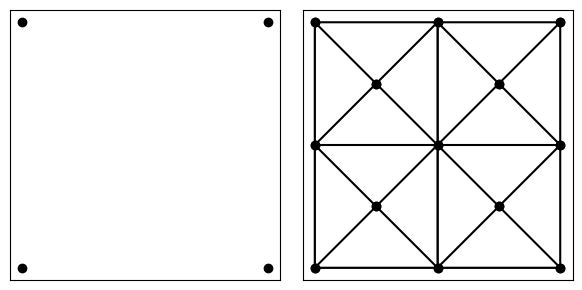

In [4]:

#edges flipping 

for i in range(len(B['edges'])):
    ii=B['edges'][i][0]
    jj=B['edges'][i][1]

    if ii>jj:
            B['edges'][i][0],B['edges'][i][1]=B['edges'][i][1],B['edges'][i][0]

tr.compare(plt, A, B)

print(B['edges'])

In [5]:

#util functions

def get_triangle_edges(triangle_vertices,edges):
    triangle_edges = []
 

    keep=np.zeros((3,),dtype=np.int64)

    for i in range(3):
        ii=triangle_vertices[i].copy()
        jj=triangle_vertices[(i + 1) % 3].copy()
        

        if(ii>jj):
            edge=np.array([jj,ii])
        else:
            edge=np.array([ii,jj])

        index= np.where(np.all(edges == edge, axis=1))[0][0]
        
        triangle_edges.append(index)

        if ii>jj:
            keep[i]=1

    triangle_edges=np.array(triangle_edges)
        
    return keep,triangle_edges

In [6]:
l=[]
temp=[]
for triangle in B['triangles']:
    keep,t=get_triangle_edges(triangle,B['edges'])
    l.append(keep)
    temp.append(t)



keep=np.asarray(l)
edges_index_inside_triangle=np.asarray(temp)

In [7]:
B['keep']=keep
B['edges_index_inside_triangle']=edges_index_inside_triangle

In [8]:
B.keys()

dict_keys(['vertices', 'vertex_markers', 'triangles', 'neighbors', 'edges', 'edge_markers', 'keep', 'edges_index_inside_triangle'])

In [9]:
n_vertices=len(B['vertices'])
n_traingles=len(B['triangles'])
n_edges=len(B['edges'])

n_inside_edge=basis.n_inside_edge
n_inside=basis.n_inside

vertices_contribution=np.zeros((n_vertices,1))
edges_contribution=np.zeros((n_edges,n_inside_edge))
inside_contribution=np.zeros((n_traingles,n_inside))




for index,triangle in enumerate(B['triangles']):


    if (B['vertex_markers'][triangle[0]]==0):
            vertices_contribution[triangle[0]]=1
    else:
          vertices_contribution[triangle[0]]=2

    if (B['vertex_markers'][triangle[1]]==0):
            vertices_contribution[triangle[1]]=1
    else:
          vertices_contribution[triangle[1]]=2    

    if (B['vertex_markers'][triangle[2]]==0):
            vertices_contribution[triangle[2]]=1
    else:
          vertices_contribution[triangle[2]]=2
    

    if(B['edge_markers'][B['edges_index_inside_triangle'][index][0]]==0):
           
           edges_contribution[B['edges_index_inside_triangle'][index][0]]+=3

    if(B['edge_markers'][B['edges_index_inside_triangle'][index][1]]==0):
           edges_contribution[B['edges_index_inside_triangle'][index][1]]+=3

    if(B['edge_markers'][B['edges_index_inside_triangle'][index][2]]==0):
           edges_contribution[B['edges_index_inside_triangle'][index][2]]+=3      



print(B['edges'])
print(edges_contribution)


    
                                   

[[ 4 12]
 [ 9 12]
 [ 4  9]
 [ 4  8]
 [ 4  5]
 [ 5  8]
 [ 7 10]
 [ 3  7]
 [ 3 10]
 [ 3  5]
 [ 5 10]
 [ 4  6]
 [ 6 12]
 [ 6  8]
 [ 0  6]
 [ 0  8]
 [ 2 11]
 [ 2  7]
 [ 7 11]
 [ 0  5]
 [ 2  9]
 [ 9 11]
 [ 4  7]
 [ 4 10]
 [ 4 11]
 [ 1  9]
 [ 1 12]
 [ 1  6]]
[[6.]
 [6.]
 [6.]
 [6.]
 [6.]
 [6.]
 [6.]
 [0.]
 [6.]
 [0.]
 [6.]
 [6.]
 [6.]
 [6.]
 [0.]
 [6.]
 [6.]
 [0.]
 [6.]
 [0.]
 [0.]
 [6.]
 [6.]
 [6.]
 [6.]
 [0.]
 [6.]
 [0.]]
